# Sampler statistics

When checking for convergence or when debugging a badly behaving
sampler, it is often helpful to take a closer look at what the
sampler is doing. For this purpose some samplers export
statistics for each generated sample.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%matplotlib inline

print(f"Runing on PyMC3 v{pm.__version__}")

Runing on PyMC3 v3.11.2


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

As a minimal example we sample from a standard normal distribution:

In [3]:
model = pm.Model()
with model:
    mu1 = pm.Normal("mu1", mu=0, sigma=1, shape=10)

In [4]:
with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000, init=None, step=step, cores=2, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.


NUTS provides the following statistics:
- `Note`: To learn more about NUTS statistics, [check this page](https://docs.pymc.io/api/inference.html#module-pymc3.step_methods.hmc.nuts)

In [5]:
trace.sample_stats

<xarray.Dataset>
Dimensions:             (chain: 2, draw: 2000)
Coordinates:
  * chain               (chain) int64 0 1
  * draw                (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
Data variables: (12/13)
    n_steps             (chain, draw) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
    acceptance_rate     (chain, draw) float64 0.3946 1.0 ... 0.7429 0.9799
    diverging           (chain, draw) bool False False False ... False False
    lp                  (chain, draw) float64 -23.23 -18.3 ... -19.85 -20.25
    perf_counter_diff   (chain, draw) float64 0.0004298 0.0004191 ... 0.0003205
    tree_depth          (chain, draw) int64 2 2 2 2 2 2 2 2 ... 2 2 2 3 2 2 2 2
    ...                  ...
    max_energy_error    (chain, draw) float64 1.515 -1.358 ... 1.001 -0.9029
    perf_counter_start  (chain, draw) float64 6.197 6.198 6.198 ... 8.621 8.621
    step_size           (chain, draw) float64 0.7602 0.7602 ... 1.231 1.231
    step_size_bar       (chain, draw) float64 0.9333 0.9333 ... 0.959 0.959
    energy_error        (chain, draw) float64 1.515 -1.358 ... 1.001 0.1039
    energy              (chain, draw) float64 28.66 27.65 25.17 ... 24.42 26.31
Attributes:
    created_at:                 2021-04-04T13:14:18.324217
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              9.566201210021973
    tuning_steps:               1000

[Arviz](https://arviz-devs.github.io/arviz/schema/schema.html#sample-stats) follows the following Name Convention for sample_stats variables, these may vary depending on the algorithm used by the backend (i.e. an affine invariant sampler has no energy associated). Therefore none of these parameters should be assumed to be present in the sample_stats group. The convention below serves to ensure that if a variable is present with one of these names it will correspond to the definition included here:

- `process_time_diff`: The time it took to draw the sample, as defined by the python standard library time.process_time. This counts all the CPU time, including worker processes in BLAS and OpenMP.

- `step_size`: The current integration step size.

- `diverging`: (boolean) Indicates the presence of leapfrog transitions with large energy deviation from starting and subsequent termination of the trajectory. “large” is defined as `max_energy_error` going over a threshold.

- `lp`: The joint log posterior density for the model (up to an additive constant).

- `energy`: The value of the Hamiltonian energy for the accepted proposal (up to an additive constant).

- `energy_error`: The difference in the Hamiltonian energy between the initial point and the accepted proposal.

- `perf_counter_diff`: The time it took to draw the sample, as defined by the python standard library time.perf_counter (wall time).

- `perf_counter_start`: The value of time.perf_counter at the beginning of the computation of the draw.

- `n_steps`: The number of leapfrog steps computed. It is related to `tree_depth` with `n_steps <= 2^tree_dept`.

- `max_energy_error`: The maximum absolute difference in Hamiltonian energy between the initial point and all possible samples in the proposed tree.

- `acceptance_rate`: The average acceptance probabilities of all possible samples in the proposed tree.

- `step_size_bar`: The current best known step-size. After the tuning samples, the step size is set to this value. This should converge during tuning.

- `tree_depth`: The number of tree doublings in the balanced binary tree.

- `tune`: This is True, if step size adaptation was turned on when this sample was generated.

InferenceData also stores additional info like the date, versions used, sampling time and tuning steps as attributes.

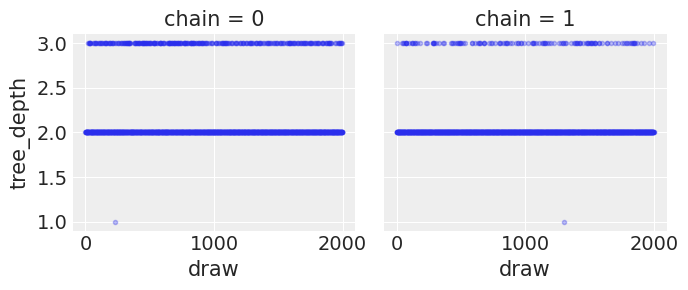

In [6]:
trace.sample_stats["tree_depth"].plot(col="chain", ls="none", marker=".", alpha=0.3);

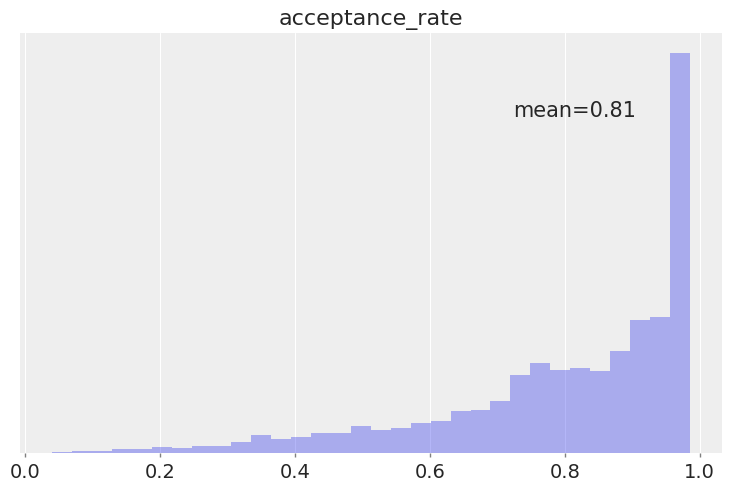

In [7]:
az.plot_posterior(
    trace, group="sample_stats", var_names="acceptance_rate", hdi_prob="hide", kind="hist"
);

We check if there are any divergences, if yes, how many?

In [8]:
trace.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In this case no divergences are found. If there are any, check [this notebook](https://github.com/pymc-devs/pymc-examples/blob/main/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.ipynb) for  information on handling divergences.

It is often useful to compare the overall distribution of the
energy levels with the change of energy between successive samples.
Ideally, they should be very similar:

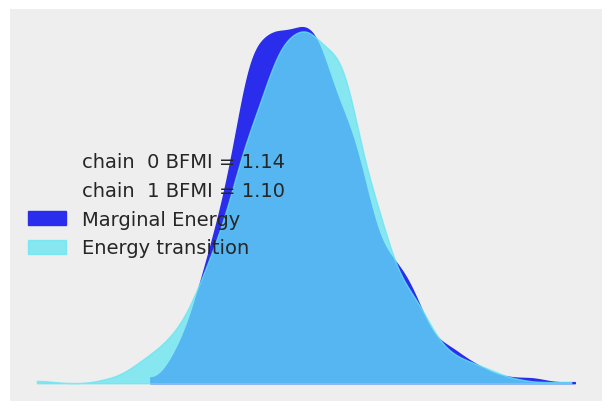

In [9]:
az.plot_energy(trace, figsize=(6, 4));

If the overall distribution of energy levels has longer tails, the efficiency of the sampler will deteriorate quickly.

## Multiple samplers

If multiple samplers are used for the same model (e.g. for continuous and discrete variables), the exported values are merged or stacked along a new axis.


In [10]:
coords = {"step": ["BinaryMetropolis", "Metropolis"]}
dims = {"accept": ["step"]}

with pm.Model(coords=coords) as model:
    mu1 = pm.Bernoulli("mu1", p=0.8, dims="step")
    mu2 = pm.Normal("mu2", mu=0, sigma=1, dims="step")

In [11]:
with model:
    step1 = pm.BinaryMetropolis([mu1])
    step2 = pm.Metropolis([mu2])
    trace = pm.sample(
        10000,
        init=None,
        step=[step1, step2],
        cores=2,
        tune=1000,
        return_inferencedata=True,
        idata_kwargs={"dims": dims, "coords": coords},
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryMetropolis: [mu1]
>Metropolis: [mu2]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
list(trace.sample_stats.data_vars)

['accept', 'p_jump', 'scaling', 'accepted']

Both samplers export `accept`, so we get one acceptance probability for each sampler:

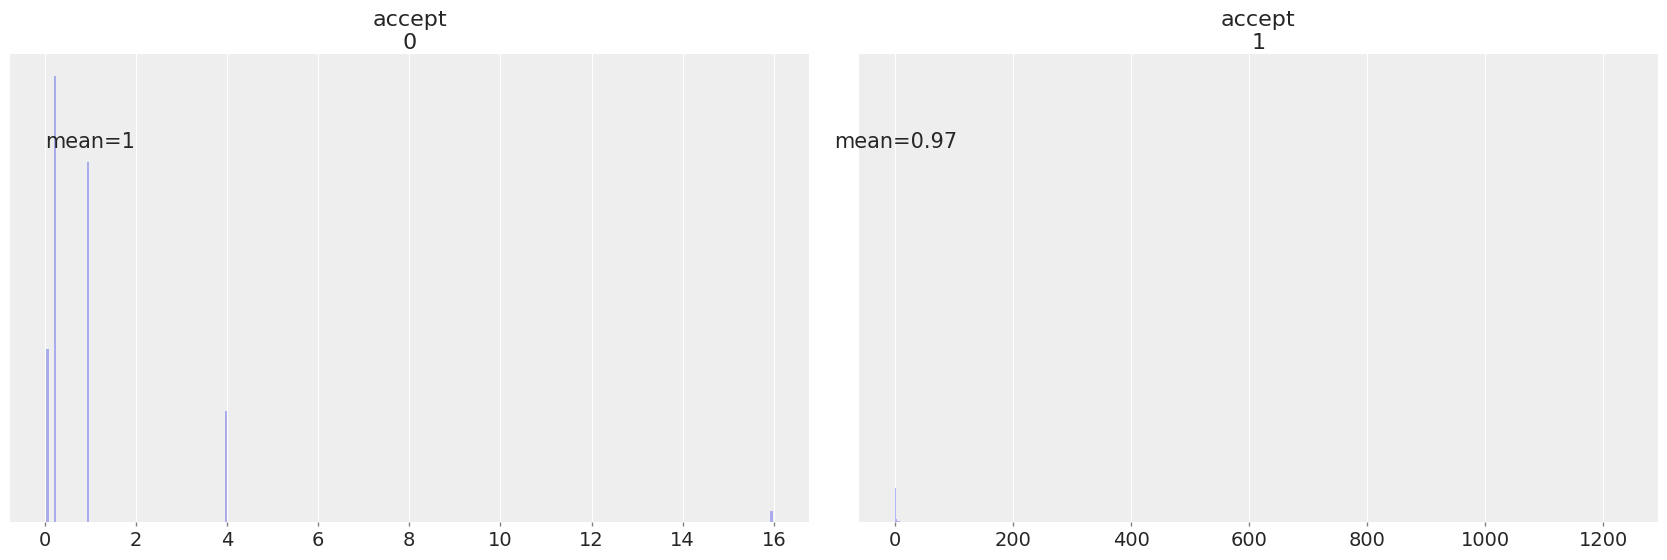

In [13]:
az.plot_posterior(
    trace,
    group="sample_stats",
    var_names="accept",
    hdi_prob="hide",
    kind="hist",
);

We notice that accept variable takes really large values, as outliers in accept 1

In [14]:
# The outliers are the values reaching upto ~1200
np.ptp(trace.sample_stats["accept"].values, axis=1)

array([[  15.9375    , 1230.85829008],
       [  15.9375    ,  161.88043405]])

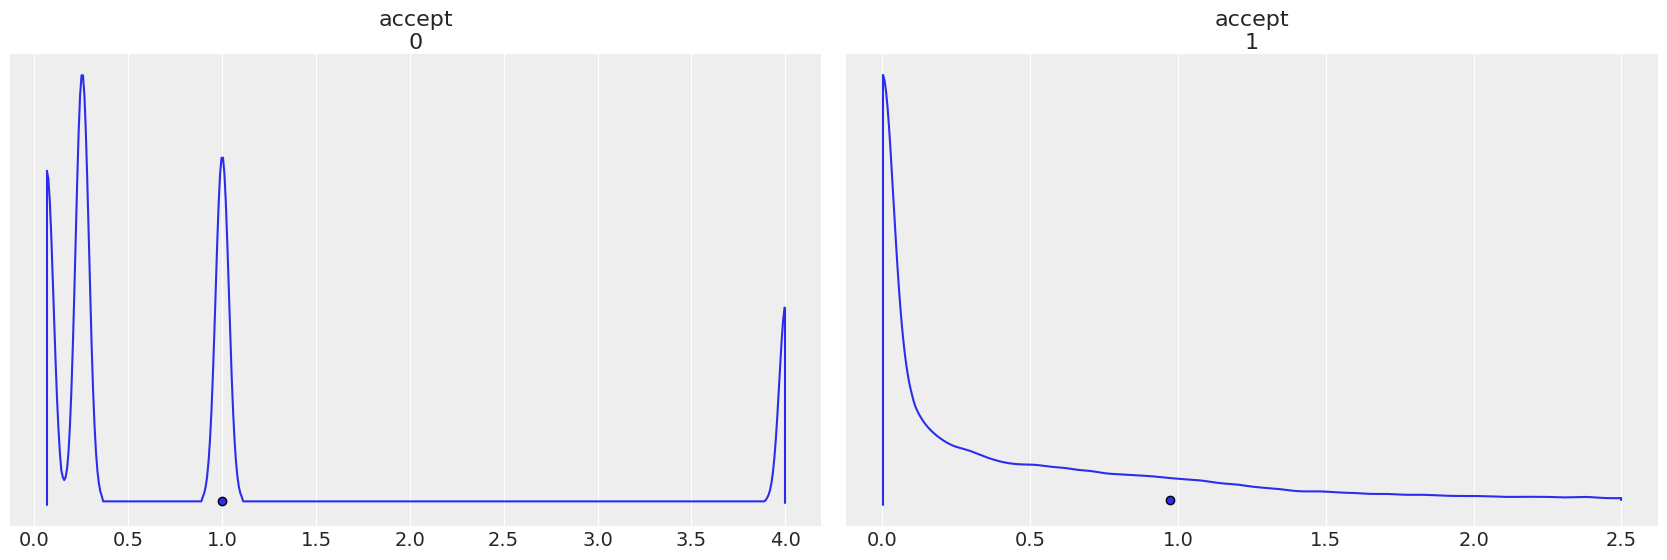

In [15]:
# We can try plotting the density and view the high density intervals to understand the variable better
az.plot_density(
    trace,
    group="sample_stats",
    var_names="accept",
    point_estimate="mean",
);

In [16]:
pm.summary(trace.sample_stats)

/Users/almostmeenal/anaconda3/envs/p/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/almostmeenal/anaconda3/envs/p/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
accept[0],1.002,1.875,0.062,4.000,0.012,0.009,14811.0,13064.0,1.000000e+00
accept[1],0.971,9.611,0.000,2.501,0.068,0.048,20212.0,15849.0,1.000000e+00
p_jump,0.500,0.000,0.500,0.500,0.000,0.000,20000.0,20000.0,NaN
scaling,1.398,0.067,1.331,1.464,0.047,0.040,2.0,2.0,9.919727e+15
accepted,0.428,0.495,0.000,1.000,0.004,0.003,19009.0,19009.0,1.000000e+00


In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Apr 04 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

pymc3     : 3.11.2
pandas    : 1.2.3
seaborn   : 0.11.1
numpy     : 1.20.1
arviz     : 0.11.2
matplotlib: 3.3.4

Watermark: 2.2.0

